In [1]:
import pandas
import matplotlib.pyplot as plt

data = pandas.read_csv('data.csv', usecols=range(1, 11))

data.head(n=5)

,Name,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,Martine of Martine's Table,Amsterdam,"['French', 'Dutch', 'European']",1.0,5.0,$$ - $$$,136.0,"[['Just like home', 'A Warm Welcome to Wintry ...",/Restaurant_Review-g188590-d11752080-Reviews-M...,d11752080
1,De Silveren Spiegel,Amsterdam,"['Dutch', 'European', 'Vegetarian Friendly', '...",2.0,4.5,$$$$,812.0,"[['Great food and staff', 'just perfect'], ['0...",/Restaurant_Review-g188590-d693419-Reviews-De_...,d693419
2,La Rive,Amsterdam,"['Mediterranean', 'French', 'International', '...",3.0,4.5,$$$$,567.0,"[['Satisfaction', 'Delicious old school restau...",/Restaurant_Review-g188590-d696959-Reviews-La_...,d696959
3,Vinkeles,Amsterdam,"['French', 'European', 'International', 'Conte...",4.0,5.0,$$$$,564.0,"[['True five star dinner', 'A superb evening o...",/Restaurant_Review-g188590-d1239229-Reviews-Vi...,d1239229
4,Librije's Zusje Amsterdam,Amsterdam,"['Dutch', 'European', 'International', 'Vegeta...",5.0,4.5,$$$$,316.0,"[['Best meal.... EVER', 'super food experience...",/Restaurant_Review-g188590-d6864170-Reviews-Li...,d6864170


In [2]:
data.loc[0]

Name                                        Martine of Martine's Table
City                                                         Amsterdam
Cuisine Style                          ['French', 'Dutch', 'European']
Ranking                                                              1
Rating                                                               5
Price Range                                                   $$ - $$$
Number of Reviews                                                  136
Reviews              [['Just like home', 'A Warm Welcome to Wintry ...
URL_TA               /Restaurant_Review-g188590-d11752080-Reviews-M...
ID_TA                                                        d11752080
Name: 0, dtype: object

In [3]:
isLjubljana = data['City'] == 'Ljubljana'
data_lj = data[isLjubljana]

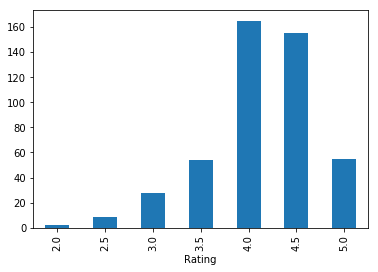

In [4]:
###############################################
# Restaurant rating distribution in Ljubljana #
###############################################

ratings_lj = data_lj['Rating']
vc = ratings_lj.value_counts().sort_index()
ax = vc.plot(kind='bar').set(xlabel="Rating")
plt.show()

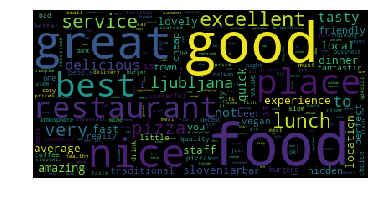

In [5]:
##################################################
# Review word-cloud for restaurants in Ljubljana #
##################################################
import collections as col
import wordcloud
import nltk

occurence_counter = col.Counter()

reviews_lj = data_lj['Reviews']
for revs_restaurant in reviews_lj:
    if not isinstance(revs_restaurant, str):
        continue
    words = revs_restaurant.split(' ');
    for w in words:
        parsed_word = ''.join(c for c in w if c.isalpha()).lower()
        if parsed_word == '':
            continue
        tagged = nltk.pos_tag([parsed_word])
        
        # We want to avoid conjunctions, prepositions, determiners, adpositions and pronouns
        if tagged[0][1] not in ['CC', 'PRON', 'IN', 'DT', 'ADP']:
            occurence_counter[parsed_word] += 1
        
cloud = wordcloud.WordCloud()       
cloud = cloud.generate_from_frequencies(occurence_counter)     


plt.imshow(cloud)
plt.axis("off")
plt.show()


In [6]:
############################################
# Most popular cuisine styles in Ljubljana #
############################################

# INFO: you can parse the arrays inside strings with eval(str)

def countCuisines(data_df):
    occurence_counter = col.Counter()

    for styles in data_df['Cuisine Style']:
        if not isinstance(styles, str):
            continue
        styles_arr = eval(styles)
        for s in styles_arr:
            occurence_counter[s] += 1

    return pandas.Series(occurence_counter, name='count')



df_count = countCuisines(data_lj).to_frame().reset_index()
df_count.columns = ['Cuisine_style', 'count']
df_count = df_count.sort_values(by=['count'], ascending=False).head(n=15).reset_index()[['Cuisine_style','count']]
df_count.index = df_count.index + 1
df_count

,Cuisine_style,count
1,European,247
2,Slovenian,174
3,Vegetarian Friendly,129
4,Central European,117
5,Mediterranean,87
6,Vegan Options,65
7,Italian,64
8,Pizza,62
9,Gluten Free Options,61
10,Bar,51


In [7]:
################################################################################################
# Construct a dataframe, where the columns represent the cuisine style distribution in a city. #
################################################################################################

all_styles = set()

for styles in data['Cuisine Style']:
    if not isinstance(styles, str):
        continue
    styles_arr = eval(styles)
    for s in styles_arr:
        all_styles.add(s)

df_allstyles = pandas.Series(list(all_styles)).to_frame()
df_allstyles.columns = ['Cuisine_style']

In [8]:
# Calculate cuisine style popularity vectors for each city, normalize them and add them to dataframe

for grp in data.groupby('City'):
    df_city = grp[1]
    df_counts = countCuisines(df_city)

    # Divide count by number of all cuisine style in the dataset
    df_counts = df_counts.apply(lambda x: x / df_counts.sum())
    
    df_counts = df_counts.to_frame().reset_index()
    df_counts.columns = ['Cuisine_style', grp[0]]   # Set city name as column name
    
    df_allstyles = df_allstyles.merge(df_counts, on='Cuisine_style', how='left')

df_allstyles = df_allstyles.fillna(0.0)

df_allstyles.index = df_allstyles['Cuisine_style']
df_allstyles = df_allstyles.drop(['Cuisine_style'], axis=1)

df_allstyles.head(n=10)

,Amsterdam,Athens,Barcelona,Berlin,Bratislava,Brussels,Budapest,Copenhagen,Dublin,Edinburgh,...,Munich,Oporto,Oslo,Paris,Prague,Rome,Stockholm,Vienna,Warsaw,Zurich
Cuisine_style,,,,,,,,,,,,,,,,,,,,,
Ethiopian,0.001330,0.000449,0.000101,0.000451,0.000000,0.000413,0.000127,0.000405,0.000160,0.000000,...,0.000649,0.000000,0.000622,0.000589,0.000080,0.000497,0.000699,0.000225,0.000000,0.000892
Minority Chinese,0.000190,0.000000,0.000203,0.000000,0.001067,0.000000,0.000000,0.000000,0.000000,0.000153,...,0.000487,0.000000,0.000311,0.000111,0.000080,0.000055,0.000175,0.000000,0.000000,0.000000
Fujian,0.000095,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000080,0.000055,0.000000,0.000113,0.000000,0.000000
Swiss,0.000570,0.000225,0.000152,0.001127,0.000000,0.000275,0.000127,0.000000,0.000000,0.000153,...,0.000325,0.000000,0.000000,0.000184,0.000160,0.000055,0.000175,0.000225,0.000000,0.076477
Fast Food,0.012447,0.020445,0.015966,0.017812,0.018133,0.016375,0.023010,0.024109,0.024019,0.029300,...,0.010711,0.009473,0.019583,0.013002,0.029643,0.016855,0.012935,0.008555,0.011715,0.012932
Portuguese,0.001045,0.000000,0.000405,0.001278,0.000533,0.003991,0.000127,0.000000,0.000961,0.001984,...,0.000811,0.233231,0.000311,0.001621,0.000080,0.000055,0.000000,0.000788,0.000192,0.000669
Seafood,0.012637,0.017524,0.014851,0.009920,0.011200,0.011146,0.004831,0.009724,0.008167,0.007020,...,0.019150,0.011265,0.012434,0.006630,0.005047,0.047635,0.009089,0.009568,0.004609,0.007358
Scandinavian,0.000380,0.000000,0.000051,0.000301,0.000000,0.000275,0.000127,0.059765,0.000160,0.000610,...,0.000000,0.000000,0.048182,0.000368,0.000160,0.000166,0.053662,0.000225,0.000192,0.000446
Vegan Options,0.051401,0.066727,0.052613,0.049226,0.025600,0.033576,0.039792,0.038695,0.056045,0.071875,...,0.040896,0.037378,0.050357,0.029541,0.024275,0.065263,0.044573,0.035344,0.033801,0.037235


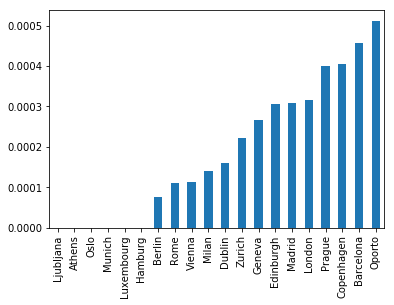

In [19]:
#########################################################################
# Find cities, where a certain cuisine style is not present yet or rare #
#########################################################################


# Belgian food:
belgian = df_allstyles.loc['Belgian'].sort_values(ascending=True).head(n=20)
belgian.plot(kind='bar')
plt.show()